In [1]:
from json import loads
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings("ignore")
from pyspark.sql.functions import col,from_json,udf
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,MapType,FloatType,ArrayType

In [2]:
spark = SparkSession.\
        builder.\
        appName("process-data").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "1024m").\
        getOrCreate()

22/12/04 15:46:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
data = spark.read.parquet('hdfs://namenode:9000/TikiCleaned/Comment')

In [4]:
data.createOrReplaceTempView('data')

In [5]:
spark.sql("""
    select clean_content,rating,sentiment,count(*) tmp from data
    where clean_content <> '' and clean_content is not null and clean_content <> ' '
    group by clean_content,rating,sentiment
    order by tmp desc
""").show()

+--------------------+------+---------+-----+
|       clean_content|rating|sentiment|  tmp|
+--------------------+------+---------+-----+
|                  ok|     5| Positive|25449|
|                 tốt|     5| Positive|13391|
|        sản phẩm tốt|     5| Positive| 4831|
|                good|     5| Positive| 4409|
|                 đẹp|     5| Positive| 4396|
|     giao hàng nhanh|     5| Positive| 3879|
|            hài lòng|     5| Positive| 3031|
|về giao hàng giao...|     5| Positive| 2887|
|sản phẩm có chất ...|     5| Positive| 2845|
|      chất lượng tốt|     5| Positive| 2406|
|             rất tốt|     5| Positive| 2384|
| sản phẩm rất xin...|     5| Positive| 2096|
|giao hàng nhanh đ...|     5| Positive| 1896|
|tôi rất thích hìn...|     5| Positive| 1866|
|         sản phẩm ok|     5| Positive| 1737|
|                ngon|     5| Positive| 1717|
|           tuyệt vời|     5| Positive| 1703|
|                  ok|     4| Positive| 1677|
|sản phẩm có chất ...|     5| Posi

In [6]:
df = spark.sql("""
    select distinct clean_content,rating,
    case
        when rating >= 4 then 2
        when rating = 3 then 1
        else 0
    end as label
    from data
    where clean_content <> '' and clean_content is not null and clean_content <> ' '
""")

In [7]:
df.count()

323824

In [8]:
df.groupby('rating').count().show()

+------+------+
|rating| count|
+------+------+
|     1| 29621|
|     3| 17646|
|     5|240672|
|     4| 25935|
|     2|  9950|
+------+------+



In [9]:
df.groupby('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1| 17646|
|    2|266607|
|    0| 39571|
+-----+------+



In [10]:
df

DataFrame[clean_content: string, rating: int, label: int]

In [ ]:
def getNGram(n):
    ngram = NGram(n=n)
    ngram.setInputCol("comment_term")
    ngram.setOutputCol("nGrams")
    df_nGram = ngram.transform(df_comment)
    result_nGram = df_nGram.withColumn('word',explode(df_nGram.nGrams))\
        .groupBy(['sentiment','word'])\
        .count()
    return result_nGram

In [62]:
from pyspark.ml.feature import Word2Vec
from pyspark.sql.functions import lower, col, split

dataset = df.select(split(df.clean_content, ' ').alias('cmt_token'),'rating', 'label')

word2Vec = Word2Vec(vectorSize=100, seed=42, inputCol="cmt_token", outputCol="features")
word2Vec.setMaxIter(5)
model = word2Vec.fit(dataset)

res = model.transform(dataset)
res.show()

+--------------------+------+-----+--------------------+
|           cmt_token|rating|label|            features|
+--------------------+------+-----+--------------------+
|[micro, nhỏ, gọn,...|     5|    2|[-0.0267339327861...|
|[giao, dây, tróc,...|     2|    0|[0.06681648490484...|
|[cối, thủy, tinh,...|     5|    2|[0.05081051501218...|
|[mình, đả, nhận, ...|     5|    2|[-0.0172826757556...|
|[ổn, trong, tầm, ...|     5|    2|[0.12487213272187...|
|[giày, đẹp, nhìn,...|     5|    2|[0.27593742949622...|
|[lõi, bằng, chất,...|     3|    1|[-0.0459786405448...|
|[máy, chất, lượng...|     5|    2|[0.02319451328366...|
|[bóng, đẹp, sờ, v...|     5|    2|[0.03539467820276...|
|[dây, kính, thanh...|     5|    2|[0.03577601377261...|
|[đa, nha, n, đu, ...|     5|    2|[-0.2365505701872...|
|[máy, nghe, rất, ...|     5|    2|[-0.1609528772532...|
|[tăng, che, rộng,...|     5|    2|[0.07171569915601...|
|[hàng, dùng, chất...|     5|    2|[0.04758290760219...|
|[nhà, mình, từng,...|     5|  

In [63]:
from pyspark.ml.clustering import KMeans
kmeans_val = KMeans(k=3, seed=1)
model = kmeans_val.fit(res.select('features'))

In [64]:
transformed = model.transform(res)

In [66]:
transformed.groupby('prediction').agg({'rating':'avg'}).show()

+----------+-----------------+
|prediction|      avg(rating)|
+----------+-----------------+
|         1|4.182274178738334|
|         2|4.759746533007843|
|         0|4.141603141603142|
+----------+-----------------+



In [68]:
result = transformed.select(['rating','label','prediction']).toPandas()

In [80]:
result.head()

,rating,label,prediction
0,5,2,1
1,5,2,2
2,5,2,1
3,2,0,1
4,5,2,2


In [83]:
a = result['label'].values
b = result['prediction'].values

In [84]:
from numpy import dot
from numpy.linalg import norm

cos_sim = dot(a, b)/(norm(a)*norm(b))

In [85]:
cos_sim

0.8900573664672334

In [71]:
import matplotlib.pyplot as plt

In [90]:
result0 = result[result['prediction'] == 0]
result1 = result[result['prediction'] == 1]
result2 = result[result['prediction'] == 2]

In [91]:
import seaborn as sns

(array([1019.,    0.,  410.,    0.,    0.,  649.,    0.,  828.,    0.,
        5752.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

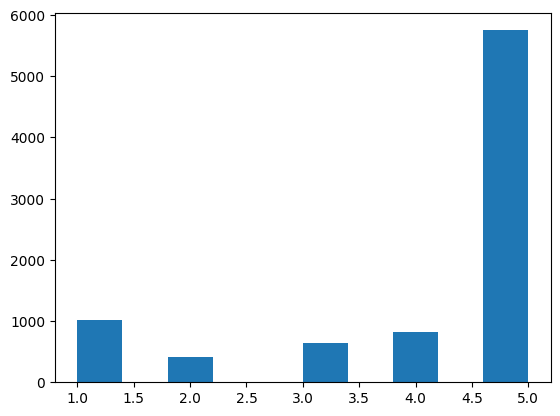

In [93]:
plt.hist(result0['rating'])

(array([ 25720.,      0.,   8701.,      0.,      0.,  15056.,      0.,
         19906.,      0., 149518.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

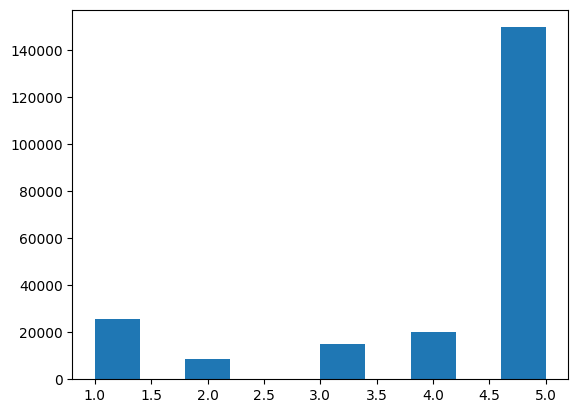

In [94]:
plt.hist(result1['rating'])

(array([ 2882.,     0.,   839.,     0.,     0.,  1941.,     0.,  5201.,
            0., 85402.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

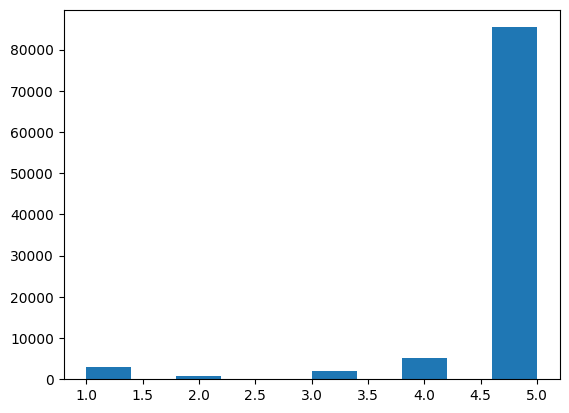

In [95]:
plt.hist(result2['rating'])

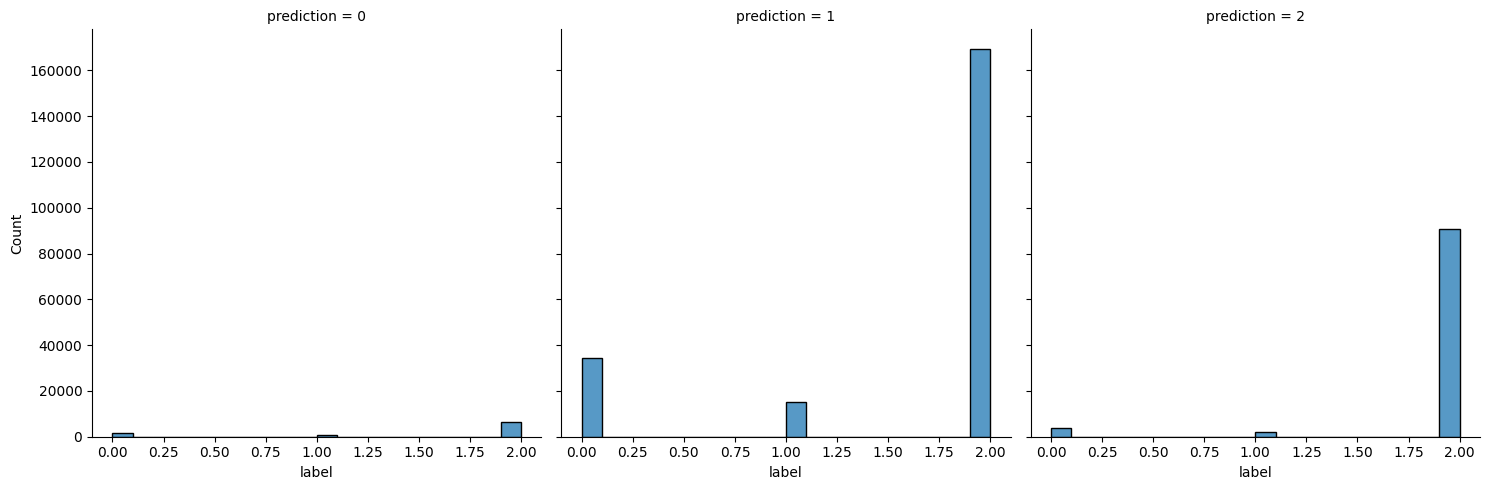

In [97]:
sns.displot(result, x="label", col="prediction")

In [65]:
transformed.show()

+--------------------+------+-----+--------------------+----------+
|           cmt_token|rating|label|            features|prediction|
+--------------------+------+-----+--------------------+----------+
|[micro, nhỏ, gọn,...|     5|    2|[-0.0267339327861...|         1|
|[giao, dây, tróc,...|     2|    0|[0.06681648490484...|         1|
|[cối, thủy, tinh,...|     5|    2|[0.05081051501218...|         1|
|[mình, đả, nhận, ...|     5|    2|[-0.0172826757556...|         1|
|[ổn, trong, tầm, ...|     5|    2|[0.12487213272187...|         1|
|[giày, đẹp, nhìn,...|     5|    2|[0.27593742949622...|         2|
|[lõi, bằng, chất,...|     3|    1|[-0.0459786405448...|         1|
|[máy, chất, lượng...|     5|    2|[0.02319451328366...|         2|
|[bóng, đẹp, sờ, v...|     5|    2|[0.03539467820276...|         1|
|[dây, kính, thanh...|     5|    2|[0.03577601377261...|         1|
|[đa, nha, n, đu, ...|     5|    2|[-0.2365505701872...|         0|
|[máy, nghe, rất, ...|     5|    2|[-0.160952877